<a href="https://colab.research.google.com/github/AEydi/rsna-pneumonia-detection/blob/main/RSNA_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### What Is Pneumonia?
Pneumonia, an inflammatory condition of the lungs, primarily affects the tiny air sacs called alveoli. Typical symptoms encompass a combination of a productive or dry cough, chest pain, fever, and breathing difficulties. The severity of the condition can vary. Pneumonia is commonly the result of viral or bacterial infections, though occasionally it may stem from other microorganisms, specific medications, or underlying conditions like autoimmune diseases. Risk factors encompass conditions such as cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, compromised coughing ability following conditions like stroke, and a weakened immune system.




### Impact of Pneumonia
Pneumonia represents a significant global health concern, contributing to more than 15% of all fatalities among children under the age of 5 worldwide. In 2015, approximately 920,000 children under the age of 5 succumbed to this illness. In the United States, pneumonia accounts for more than 500,000 visits to emergency departments and led to over 50,000 fatalities in 2015, consistently ranking among the top 10 causes of death in the nation. Despite its prevalence, the accurate diagnosis of pneumonia remains a formidable challenge. It necessitates the expertise of highly trained specialists who review chest radiographs (CXR) and seek confirmation through clinical history, vital signs, and laboratory assessments. Pneumonia typically manifests as areas of increased opacity on CXR. Nevertheless, the process of diagnosing pneumonia from CXR images is intricate due to a multitude of other lung conditions, such as pulmonary edema, bleeding, atelectasis, lung cancer, or changes resulting from radiation or surgery. Beyond lung-related issues, pleural effusion, characterized by fluid in the pleural space, can also manifest as increased opacity on CXR. The comparison of CXRs taken at different times, along with correlation with clinical symptoms and history when available, assists in the diagnostic process. Given the extensive use of CXRs in medical practice, interpreting these images is compounded by factors like patient positioning and variations in the depth of inspiration. Moreover, healthcare professionals must manage the substantial workload of reviewing high volumes of images during their shifts.

# Import Requirements

### Connecting Google Drive:
Before we dive into the project, we must establish a connection to Google Drive. This will allow us to store and access our Jupyter Notebook and other essential parts such as logs.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/Colab Notebooks/Pneumonia_Detection/"

Mounted at /content/drive


### Installing Libraries:
Here we will install all the libraries we will need for our project. These libraries include `MONAI`, `pydicom`, `tqdm`, `torchmetrics`, `plotly`, `pytorch_lightning`

In [ ]:
!pip install monai==1.2.0
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
%pip install pydicom tqdm torchmetrics plotly pytorch_lightning

### Importing Libraries:
Once we've installed the required libraries, the next step is to import them into our Jupyter Notebook. We do this to make these libraries available for use throughout the notebook.

In [4]:
import os
import glob
import numpy as np
import plotly.express as px
import sklearn.metrics as metrics
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from monai.data import Dataset, DataLoader, ArrayDataset, PersistentDataset, CacheDataset, SmartCacheDataset
from monai.apps import download_and_extract

from monai.transforms import (
    Cropd,
    MapTransform,
    Compose,
    LoadImaged,
    Activationsd,
    AsDiscreted,
    LoadImaged,
    RandFlipd,
    RandAffined,
    RandRotated,
    RandZoomd,
    ScaleIntensityd,
    EnsureChannelFirstd,
    NormalizeIntensityd,
    HistogramNormalized,
    Resized,
    Rotate90d,
    Flipd,
    ToTensord,
    Lambdad
)


# ----------------- clean unnecessary libraries -----------------

import seaborn as sns
from pathlib import Path
import pydicom
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

# pytorch libraries for deep learning modelling
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import tempfile
import pkg_resources
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from monai.apps import download_and_extract

### Downloading and Extracting Data:

To address the challenge effectively, we need access to the dataset provided by RSNA and Kaggle. In this section, we'll download the dataset, which includes chest X-Ray images and related information. These images will be the cornerstone of our work, enabling us to train and test our pneumonia detection algorithms.

To download the dataset, you should login to your Kaggle account. Then, copy download link of the dataset and paste it in the code cell below. The dataset will be downloaded and extracted to the `BRATS21` folder.

Put download like in `url` variable and run the cell below.


In [3]:
url = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10338/862042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1698362887&Signature=sWYdCi26Ud%2FJjSrKfqkkdWBUoAmQkvoCocZDWqEXbvZcg7%2FrtVvmPwnjHj28ZSSN4vH4zT9kk7e9nDj1%2BZSkZZTcWe2F921EVYAHZwcRVmS8rgtIhL9NmhPgLHicMZ49wsejjOsIWYTVrXTASBAfoXz78SjpmnoKnVpkWelp9bPstNArUbUlfmvRJJiEHJqXL1e81Y4brOh5Pbex3X0Wy7dhAdjz7EuIyJqtKFjqzGGqKq%2F3EzpcTRjSbQKC5XP4yr1itJd1gN17dTbRoXbVl4Q101nh1Z8MCsTFtW4AmNCp1junKW6BQakF%2F3gqbt0QQHW9EdbnByzelpk2ChzNPQ%3D%3D&response-content-disposition=attachment%3B+filename%3Drsna-pneumonia-detection-challenge.zip"
directory = "/content/"
file_name = "RSNA.zip"
compressed_file = os.path.join(directory, file_name)
download_and_extract(url, compressed_file, directory)

BRATS21.zip: 3.66GB [00:53, 73.8MB/s]                            

2023-10-24 04:41:57,909 - INFO - Downloaded: /content/BRATS21.zip
2023-10-24 04:41:57,911 - INFO - Expected md5 is None, skip md5 check for file /content/BRATS21.zip.
2023-10-24 04:41:57,913 - INFO - Writing into directory: /content/.


# Data Exploration and Preprocessing

Here we will read the data from the CSV file and store it in a dataframe. We will also print the first 5 rows of the dataframe to get a better understanding of the data.

In [182]:
labels = pd.read_csv(directory + "/stage_2_train_labels.csv")
labels.fillna(0, inplace=True)
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

### Distribution of classes

The following code cell will show the distribution of classes in the dataset. that shows 2/3 of the patients do not have pneumonia (with target value = 0) and 1/3 of the patients have pneumonia (with target value =1)

In [183]:
pd.pivot_table(labels, index=["Target"], values=['patientId'], aggfunc='count')

patientId
Target           
0           20672
1            9555

In the dataset, certain patients exhibit multiple rows of information, signifying the presence of pneumonia in multiple locations within their lungs, which have been segmented and labeled for analysis.

In [175]:
labels['patientId'].value_counts().value_counts()

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64

Now we will delete the duplicate rows from the dataframe. We will also create `data` dictionary which will contain the path of the images and the labels.

In [184]:
labels = labels.sample(frac = 1)
labels.drop_duplicates(subset=['patientId'], inplace=True)

In [177]:
labels.set_index('patientId', inplace=True)
labels.head(10)

x      y  width  height  Target
patientId                                                                
d6ccb839-1988-4113-8233-c7698065a8a1    0.0    0.0    0.0     0.0       0
5abb604e-6aa1-4cc0-8ef0-eda7cdc047a8    0.0    0.0    0.0     0.0       0
2c68016e-5a63-4430-a834-efe5d43edd0e  125.0  646.0  184.0   137.0       1
7495b380-25a3-4dfb-9da3-630f6288728f    0.0    0.0    0.0     0.0       0
8df52c85-df58-45e1-9142-7bcdd4d22f71    0.0    0.0    0.0     0.0       0
58b9904a-1e44-40ea-86a6-c0b9d32899f9    0.0    0.0    0.0     0.0       0
32b9ab38-2dc3-471b-87d8-4a67f49bfb7c  635.0  422.0  188.0   315.0       1
497f010c-5091-467a-bc3e-2c948ee696b0    0.0    0.0    0.0     0.0       0
dcaafe3f-11bf-4341-8c3e-5f65c7dc5972    0.0    0.0    0.0     0.0       0
19b1f7ba-bd40-4e8d-813d-da977b2306b3  658.0  590.0  151.0   228.0       1

In [74]:
path = "/content/stage_2_train_images/"
data_dic = []
data_dic = [{"id":id,"image": path + id + ".dcm", "label": int(label)} for id, label in zip(labels.index, labels.Target)]
#data_dic = [{"image": path + id + ".dcm", "label": int(label)} for id, label in zip(labels.index, labels.Target)]
data_dic[:5]

[{'id': '36a9f078-981f-47fd-87eb-e8be3ac35082',
  'image': '/content/stage_2_train_images/36a9f078-981f-47fd-87eb-e8be3ac35082.dcm',
  'label': 1},
 {'id': 'a77b8b2a-4755-47d4-970b-8b4accc1cda1',
  'image': '/content/stage_2_train_images/a77b8b2a-4755-47d4-970b-8b4accc1cda1.dcm',
  'label': 0},
 {'id': '168ae18f-d50a-4df3-9f21-5eedb100fcc0',
  'image': '/content/stage_2_train_images/168ae18f-d50a-4df3-9f21-5eedb100fcc0.dcm',
  'label': 0},
 {'id': '5e7a197f-e287-4d83-8094-9d7eee2d1269',
  'image': '/content/stage_2_train_images/5e7a197f-e287-4d83-8094-9d7eee2d1269.dcm',
  'label': 0},
 {'id': 'f178cab2-d7e5-49e6-a548-74c08791d2bb',
  'image': '/content/stage_2_train_images/f178cab2-d7e5-49e6-a548-74c08791d2bb.dcm',
  'label': 0}]

### Loading original images

in this section we will load the original images and metadata from the dataset. And we will extract sex and age from the metadata and add them in the
`labels` dataframe.

In [146]:
class ReadDicomd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.keys = keys
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            data = pydicom.read_file(d[key])
            d[key] = data.pixel_array
            meta_data = {attribute: getattr(data, attribute) for attribute in dir(data) if attribute[0].isupper()}
            del meta_data["PixelData"]
            d["image_meta_dict"] = meta_data
        return d

image_loader_transforms = Compose(
    [
        ReadDicomd(keys=["image"]),
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    ]
)

original_data = Dataset(data_dic, transform=image_loader_transforms)

now we should add the sex and age columns to the `labels` dataframe.

In [ ]:
for i in tqdm(range(len(original_data))):
    data = original_data[i]
    labels.at[data["id"], "sex"] = data["image_meta_dict"]["PatientSex"]
    labels.at[data["id"], "age"] = data["image_meta_dict"]["PatientAge"]
labels.fillna(0, inplace=True)
labels.head()

  0%|          | 0/26684 [00:00<?, ?it/s]

x      y  width  height  Target sex  \
patientId                                                                       
0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   F   
00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   F   
00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   M   
003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   M   
00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   F   

                                     age  
patientId                                 
0004cfab-14fd-4e49-80ba-63a80b6bddd6  51  
00313ee0-9eaa-42f4-b0ab-c148ed3241cd  48  
00322d4d-1c29-4943-afc9-b6754be640eb  19  
003d8fa0-6bf1-40ed-b54c-ac657f8495c5  28  
00436515-870c-4b36-a041-de91049b9ab4  32

### Visualizing the data

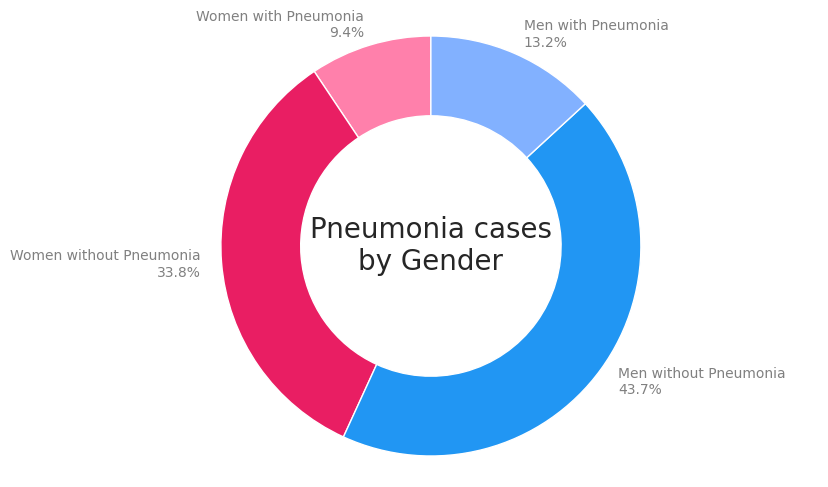

In [ ]:
cases_counts = labels.value_counts(["sex", "Target"]).to_dict()
women_with_pneumonia = cases_counts.get(('F', 1), 0)
women_without_pneumonia = cases_counts.get(('F', 0), 0)
men_with_pneumonia = cases_counts.get(('M', 1), 0)
men_without_pneumonia = cases_counts.get(('M', 0), 0)

chart_labels = ['Women with Pneumonia', 'Women without Pneumonia', 'Men without Pneumonia', 'Men with Pneumonia']
values = [women_with_pneumonia, women_without_pneumonia, men_without_pneumonia, men_with_pneumonia]

# Create a pie chart with a white center
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(values, labels=chart_labels, startangle=90,
                                  colors=['#FF80AB', '#E91E63', '#2196F3', '#82B1FF'],
                                  wedgeprops=dict(width=0.38, edgecolor='w'))  # Set width to create a white center
ax.axis('equal')

# Customize the style using Seaborn
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette(["#E91E63", "#2196F3", "#82B1FF", "#FF80AB"]))
sns.despine(left=True)

# Add a title in the center
ax.text(0, 0, "Pneumonia cases\nby Gender", ha='center', va='center', fontsize=20)

# Add percentages alongside labels
for t, at in zip(texts, autotexts):
    label = t.get_text()
    percentage = at.get_text()
    t.set_text(f"{label}\n{percentage}")
    t.set_color('gray')

plt.show()

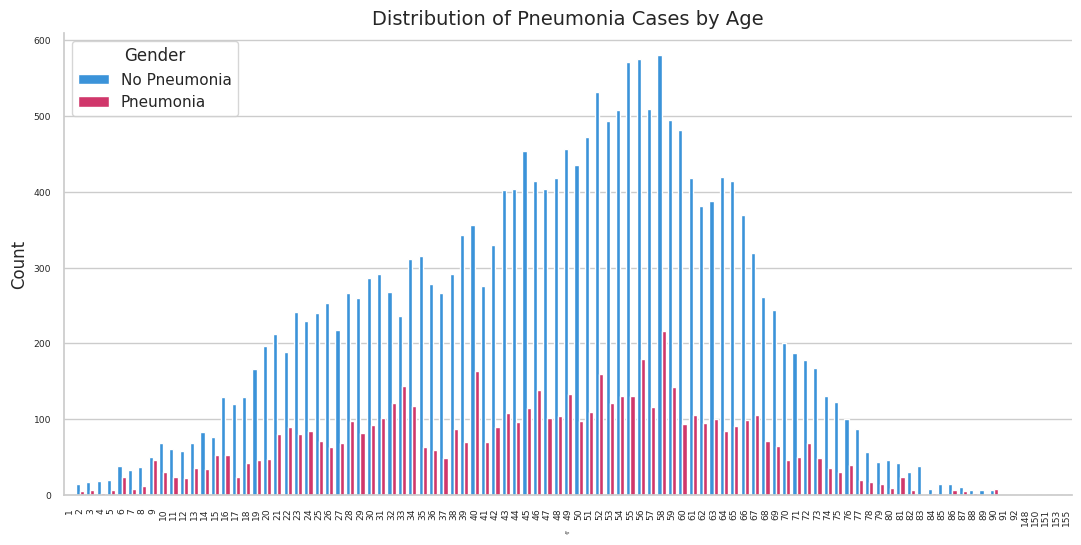

In [ ]:
# Assuming that 'labels' is a DataFrame with columns 'age' and 'Target'
cases_counts = labels.groupby(['age', 'Target']).size().reset_index(name='Counts')

# Sort the DataFrame by 'age'
cases_counts['age'] = cases_counts['age'].astype(int)

# Set a smaller font size for the plot
sns.set(font_scale=0.6)  # Adjust the scaling factor as needed

# Create a bar plot using Seaborn with sorted x-axis
plt.figure(figsize=(13, 6))
sns.set_style("whitegrid")
sns.barplot(data=cases_counts, x="age", y="Counts", hue="Target", palette={0: '#2196F3', 1: '#E91E63'})
# Remove the gridlines
sns.despine()
sns.set(style="white")
# Customize the plot
plt.title("Distribution of Pneumonia Cases by Age", fontsize=14)  # Adjust the title font size
plt.xlabel("Age", fontsize=2)  # Adjust the x-axis label font size
plt.ylabel("Count", fontsize=12)  # Adjust the y-axis label font size
plt.legend(title="Gender", labels=["No Pneumonia", "Pneumonia"], fontsize=10)  # Adjust the legend font size
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
legend = plt.legend(title="Gender")
legend.get_texts()[0].set_text("No Pneumonia")
legend.get_texts()[1].set_text("Pneumonia")

plt.show()

Visualizing images

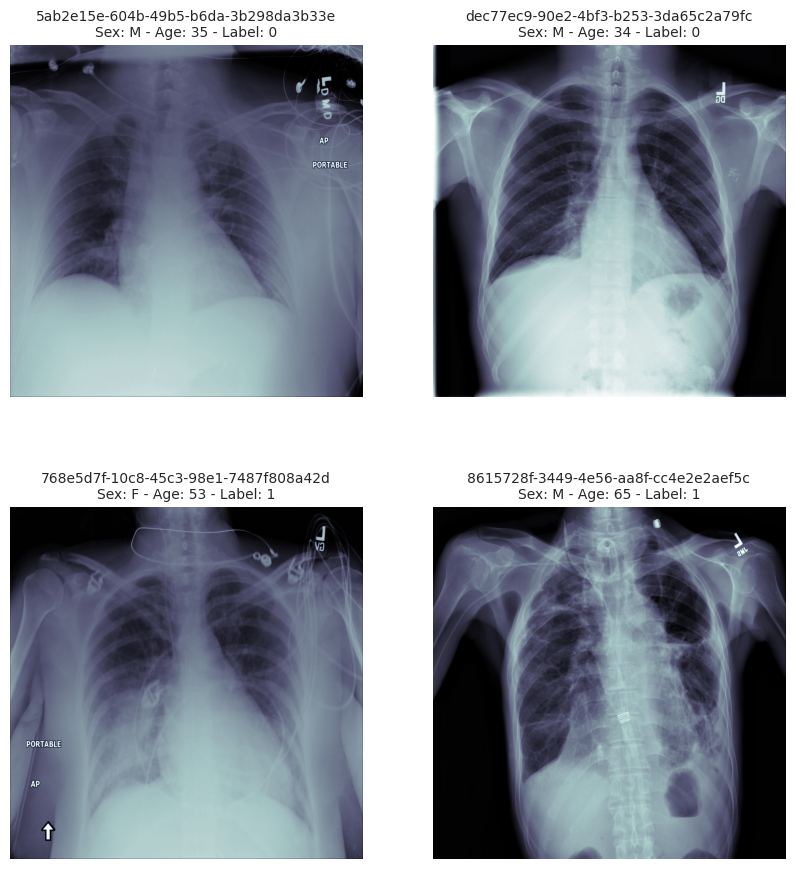

In [148]:
fig, axis = plt.subplots(2, 2, figsize=(10, 11))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, len(original_data))
        data = original_data[random_index]
        x_ray = data["image"]
        Id = data["id"]
        sex = "Sex: " + data["image_meta_dict"]["PatientSex"]
        age = "Age: " + str(data["image_meta_dict"]["PatientAge"])
        label = "Label: " + str(labels.loc[Id]["Target"])

        title = Id + "\n" + sex + " - " + age + " - " + label
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(title,fontsize=10)

        # Remove the grid from subplots
        axis[i][j].axis('off')

plt.show()

In [185]:
data_pos = labels[labels.Target == 1]
data_pos.head()

patientId      x      y  width  height  \
11082  74075cca-a426-4710-92de-e23aa74b76ac  644.0  292.0  193.0   300.0   
10839  722ad9c3-919a-4c08-bb67-cafd603ba754  607.0  220.0  183.0   325.0   
1218   104c55a0-70a6-49a7-a677-c170d356372a  192.0  398.0  249.0   282.0   
12095  7c1a130b-a944-431a-a2b1-735483a46c12  656.0  529.0  193.0   434.0   
178    05b91b32-5635-4071-b45d-6a73f8eea918  160.0  264.0  317.0   501.0   

       Target  
11082       1  
10839       1  
1218        1  
12095       1  
178         1

In [186]:
data_neg = labels[labels.Target == 0]
data_neg.head()

patientId    x    y  width  height  Target
27959  f7e14331-ae8f-4367-8ca3-93699785e0e2  0.0  0.0    0.0     0.0       0
19394  b440e00a-6791-4d75-8204-94ad0dacfe65  0.0  0.0    0.0     0.0       0
14925  92bb404a-2703-4288-ba3b-81f4d60be155  0.0  0.0    0.0     0.0       0
14825  91ce2ffb-5eb8-4f4d-afc8-af618e865f02  0.0  0.0    0.0     0.0       0
27832  f6e624f8-75fd-4f03-9119-24a617008e2b  0.0  0.0    0.0     0.0       0

In [188]:
labels = data_pos.append(data_neg[0:8000], ignore_index=True)
labels = labels.sample(frac = 1)
labels.head()

<ipython-input-188-3f141bb68d44>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



patientId      x      y  width  height  \
20447  fb99325c-b1f6-422f-8b20-b6fab98c8fcc    0.0    0.0    0.0     0.0   
21622  56bab623-fa84-4335-8874-773e5f6c966c    0.0    0.0    0.0     0.0   
1066   9df32a52-a507-4385-b49d-12fbdaeb22bf    0.0    0.0    0.0     0.0   
4962   370e4257-86fb-40b7-a4df-b8a3a7b25226  181.0  157.0  282.0   603.0   
2733   6a564802-a75c-4a40-957b-110303263bf7    0.0    0.0    0.0     0.0   

       Target  
20447       0  
21622       0  
1066        0  
4962        1  
2733        0

### Defining the Transformations
In this section, we will define the transformations that will be applied to the images.
The transformations include:
- Resizing the images to 224x224 as appropriate for the model
- Histogram Normalization to improve the contrast of the images
- Scaling intensity range from [0,255] to [0,1]
- Randomly rotating the images by 10 degrees
- Randomly Zooming the images by 10%

In [137]:
class ReadDicomd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.keys = keys
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            data = pydicom.read_file(d[key])
            d[key] = data.pixel_array
            meta_data = {attribute: getattr(data, attribute) for attribute in dir(data) if attribute[0].isupper()}
            del meta_data["PixelData"]
            d["image_meta_dict"] = meta_data
        return d

train_transforms = Compose(
    [
        # Deterministic non-randomized transforms
        ReadDicomd(keys=["image"]),
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        Resized(keys=["image"], spatial_size=(224, 224)),
        HistogramNormalized(keys=["image"]),
        ScaleIntensityd(keys=["image"]),

        # Randomized transforms
        RandZoomd(keys=["image"], prob=0.5, min_zoom=0.8, max_zoom=1.2),
        RandRotated(keys=["image"], prob=0.5, range_x=np.pi/18),
        ToTensord(keys=["image"]),
    ]
)

val_transforms = Compose(
    [
        # Deterministic non-randomized transforms
        ReadDicomd(keys=["image"]),
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        Resized(keys=["image"], spatial_size=(224, 224)),
        HistogramNormalized(keys=["image"]),
        ScaleIntensityd(keys=["image"]),
    ]
)

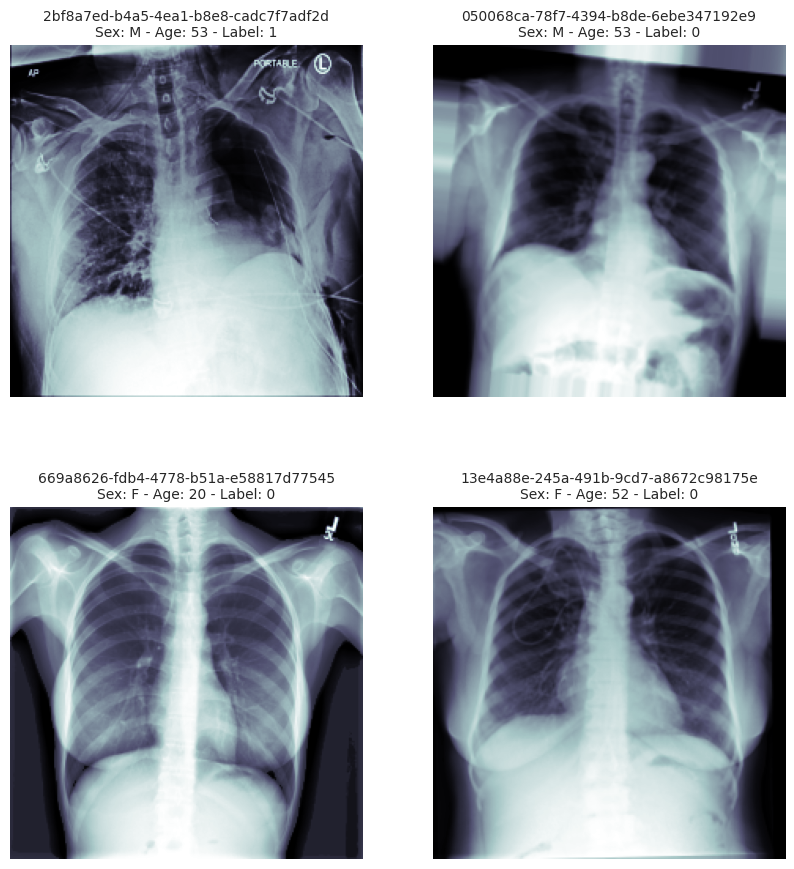

In [145]:
transformed_dataset = Dataset(data_dic, transform=train_transforms)
fig, axis = plt.subplots(2, 2, figsize=(10, 11))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, len(transformed_dataset))
        data = transformed_dataset[random_index]
        x_ray = data["image"]
        Id = data["id"]
        sex = "Sex: " + data["image_meta_dict"]["PatientSex"]
        age = "Age: " + str(data["image_meta_dict"]["PatientAge"])
        label = "Label: " + str(labels.loc[Id]["Target"])

        title = Id + "\n" + sex + " - " + age + " - " + label
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(title,fontsize=10)

        # Remove the grid from subplots
        axis[i][j].axis('off')

plt.show()

### Defining the Datasets and DataLoaders
In this section, we will define the datasets and dataloaders that will be used for training and testing the model.

In [75]:
size_of_data = len(data_dic)
size_of_train = 12000
size_of_val = 2000
train_dataset = PersistentDataset(data_dic[:size_of_train], transform=train_transforms, cache_dir="/content/cache")
val_dataset = PersistentDataset(data_dic[size_of_train:], transform=val_transforms, cache_dir="/content/cache")

In [53]:
batch_size = 100
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [54]:
# define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # resnet18 with pretrained weights
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # add dropout to the model.fc layer
        self.model.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=512, out_features=1, bias=True)
        )


        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

        # metrics
        # accuracy
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

        # precision
        self.train_precision = torchmetrics.Precision(task="binary")
        self.val_precision = torchmetrics.Precision(task="binary")

        # recall
        self.train_recall = torchmetrics.Recall(task="binary")
        self.val_recall = torchmetrics.Recall(task="binary")

        # auc
        self.train_auc = torchmetrics.AUROC(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label'].unsqueeze(1)
        y = y.float()
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        self.train_acc(torch.sigmoid(y_hat), y)
        self.train_precision(torch.sigmoid(y_hat), y)
        self.train_recall(torch.sigmoid(y_hat), y)
        self.train_auc(torch.sigmoid(y_hat), y)
        return loss

    def on_train_epoch_end(self) -> None:
        self.log("train_acc", self.train_acc.compute())
        self.log("train_precision", self.train_precision.compute())
        self.log("train_recall", self.train_recall.compute())
        self.log("train_auc", self.train_auc.compute())

    def validation_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label'].unsqueeze(1)
        y = y.float()
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss)
        self.val_acc(torch.sigmoid(y_hat), y)
        self.val_precision(torch.sigmoid(y_hat), y)
        self.val_recall(torch.sigmoid(y_hat), y)
        self.val_auc(torch.sigmoid(y_hat), y)
        return loss

    def on_validation_epoch_end(self) -> None:
        self.log("val_acc", self.val_acc.compute())
        self.log("val_precision", self.val_precision.compute())
        self.log("val_recall", self.val_recall.compute())
        self.log("val_auc", self.val_auc.compute())

    def configure_optimizers(self):
        return [self.optimizer]

model = PneumoniaModel()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.3MB/s]


In [55]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_auc",
    dirpath="checkpoints1",
    save_top_k=3,
    mode="max",
)

In [56]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=20,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    logger=CSVLogger(save_dir=directory + "/log", name="pneumonia"),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [57]:
trainer.fit(model, train_loader, val_loader)
torch.save(model.state_dict(), os.path.join(directory, "pneumonia_model.pt"))

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type              | Params
------------------------------------------------------
0 | model           | ResNet            | 11.2 M
1 | loss_fn         | BCEWithLogitsLoss | 0     
2 | train_acc       | BinaryAccuracy    | 0     
3 | val_acc         | BinaryAccuracy    | 0     
4 | train_precision | BinaryPrecision   | 0     
5 | val_precision   | BinaryPrecision   | 0     
6 | train_recall    | BinaryRecall      | 0     
7 | val_recall      | BinaryRecall      | 0     
8 | train_auc       | BinaryAUROC       | 0     
9 | val_auc         | BinaryAUROC       | 0     
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


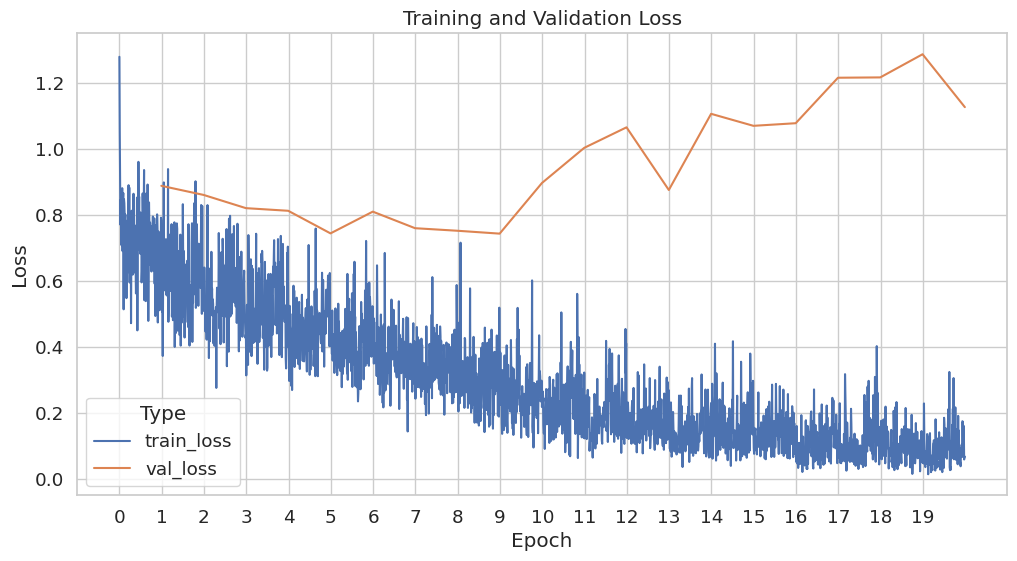

In [172]:
# plot the training and validation loss
loss_df = pd.read_csv(directory + "/metrics (4).csv")
loss_df = loss_df[["step", "epoch", "train_loss", "val_loss"]]
loss_df = loss_df.melt(id_vars="step", value_vars=["train_loss", "val_loss"], var_name="type", value_name="loss")
loss_df["step"] = loss_df["step"].astype(int)


plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the line plot
g = sns.lineplot(data=loss_df, x="step", y="loss", hue="type")
g.set(title="Training and Validation Loss", xlabel="Epoch", ylabel="Loss")
g.legend(title="Type")
plt.xticks(range(0, 2400, 120), range(20))

plt.show()

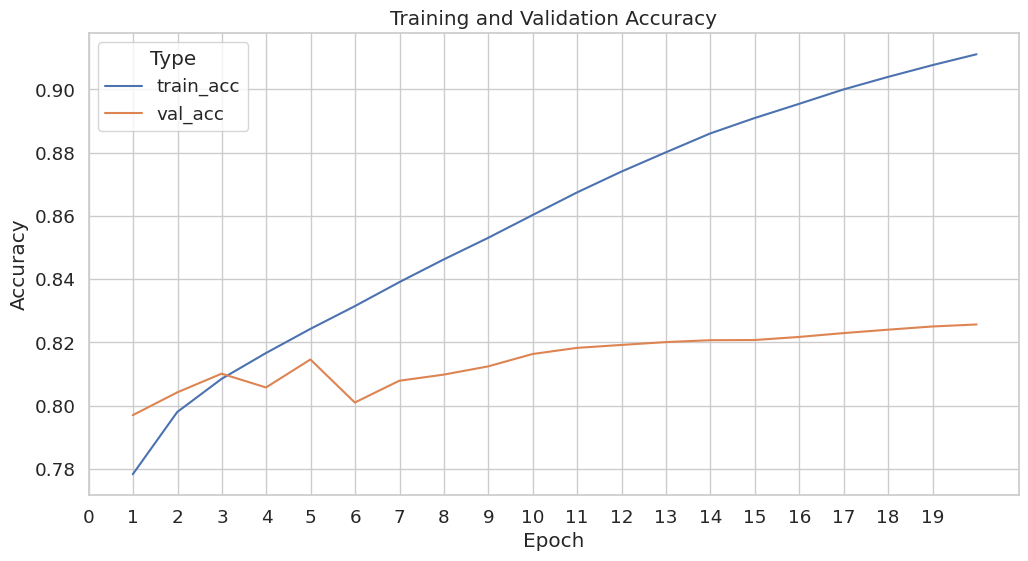

In [135]:
# Read the precision data
acc_df = pd.read_csv(directory + "/log/pneumonia/version_0/metrics.csv")
acc_df = acc_df[["step", "epoch", "train_acc", "val_acc"]]
acc_df = acc_df.melt(id_vars="step", value_vars=["train_acc", "val_acc"], var_name="type", value_name="accuracy")
acc_df["step"] = acc_df["step"].astype(int)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the line plot
g = sns.lineplot(data=acc_df, x="step", y="accuracy", hue="type")
g.set(title="Training and Validation Accuracy", xlabel="Epoch", ylabel="Accuracy")
g.legend(title="Type")
plt.xticks(range(0, 2400, 120), range(20))

plt.show()

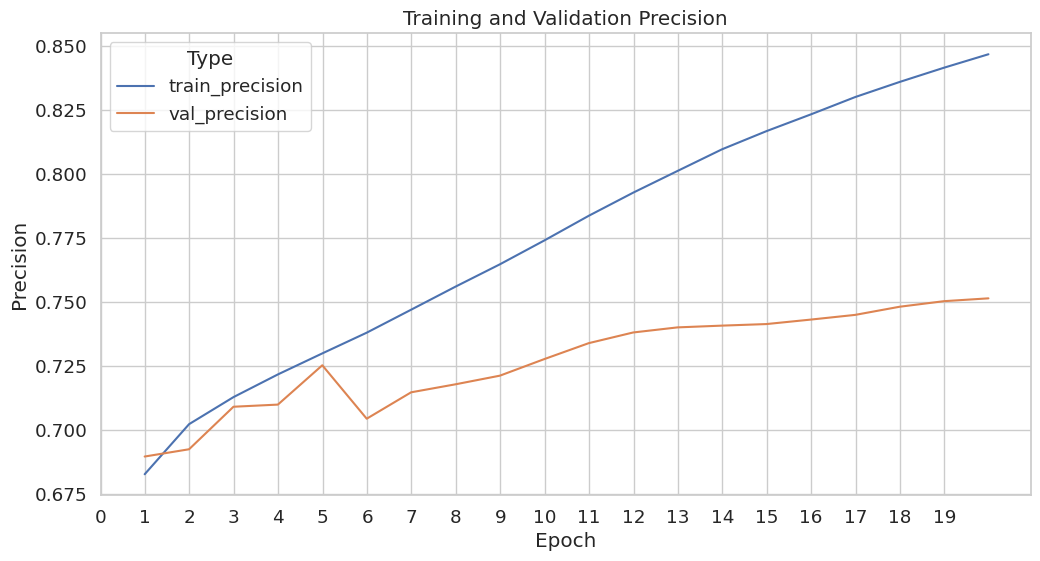

In [162]:
# Read the precision data
precision_df = pd.read_csv(directory + "metrics (3).csv")
precision_df = precision_df[["step", "epoch", "train_precision", "val_precision"]]
precision_df = precision_df.melt(id_vars="step", value_vars=["train_precision", "val_precision"], var_name="type", value_name="precision")
precision_df["step"] = precision_df["step"].astype(int)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the line plot
g = sns.lineplot(data=precision_df, x="step", y="precision", hue="type")
g.set(title="Training and Validation Precision", xlabel="Epoch", ylabel="Precision")
g.legend(title="Type")
plt.xticks(range(0, 2400, 120), range(20))

plt.show()

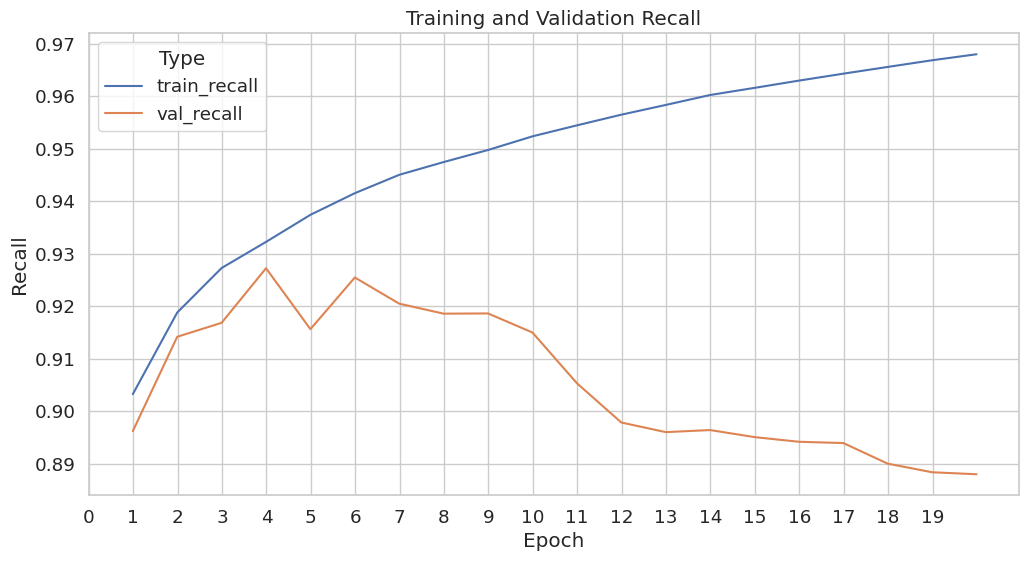

In [132]:
# Read the recall data
recall_df = pd.read_csv(directory + "/log/pneumonia/version_0/metrics.csv")
recall_df = recall_df[["step", "epoch", "train_recall", "val_recall"]]
recall_df = recall_df.melt(id_vars="step", value_vars=["train_recall", "val_recall"], var_name="type", value_name="recall")
recall_df["step"] = recall_df["step"].astype(int)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the line plot
g = sns.lineplot(data=recall_df, x="step", y="recall", hue="type")
g.set(title="Training and Validation Recall", xlabel="Epoch", ylabel="Recall")
g.legend(title="Type")
plt.xticks(range(0, 2400, 120), range(20))

plt.show()

In [ ]:
model = PneumoniaModel.load_from_checkpoint(checkpoint_callback.best_model_path)
model.eval()
model.to(device)
y_preds = np.zeros(len(val_dataset))
y_true = np.zeros(len(val_dataset))
i = 0
k = 0
with torch.no_grad():
    for batch in val_loader:
        x, y = batch['image'], batch['label'].unsqueeze(1)
        x = x.to(device).float()
        y_hat = torch.sigmoid(model(x)).cpu()
        y_hat = y_hat[:, 0].numpy()
        y = y[:, 0].numpy()
        for j in range(len(y_hat)):
            y_preds[i] = y_hat[j]
            y_true[i] = y[j]
            i+=1

y_preds = torch.tensor(y_preds)
y_true = torch.tensor(y_true).int()


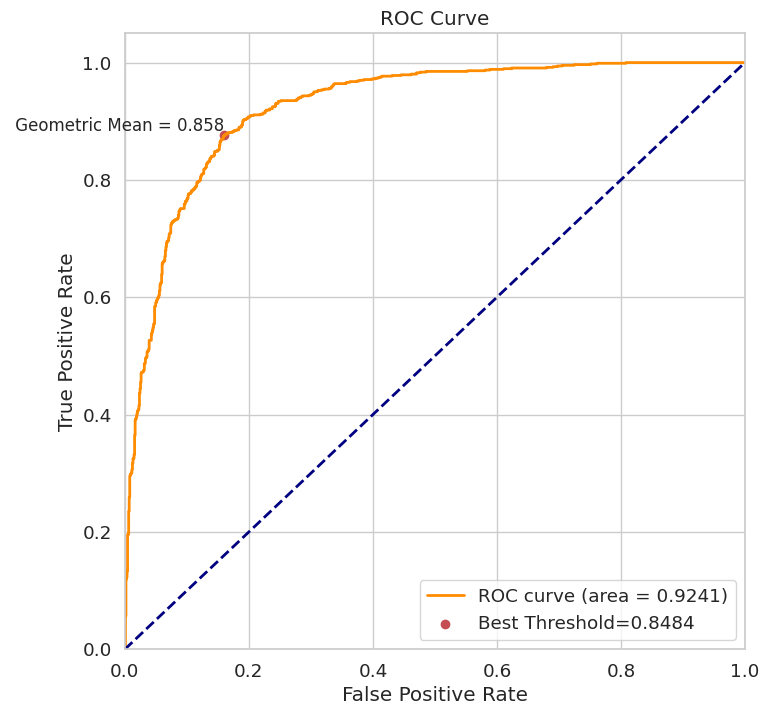

In [171]:
fpr, tpr, thresholds = torchmetrics.ROC(task="binary")(y_preds, y_true)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds.numpy()[ix]
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %.4f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='r', label='Best Threshold=%.4f' % thresholds[ix])
plt.text(fpr[ix], tpr[ix], f' Geometric Mean = {gmeans[ix]:.3f}', fontsize=12, ha='right', va='bottom')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()

In [165]:
acc = torchmetrics.Accuracy(task="binary", threshold=best_threshold)(y_preds, y_true)
precision = torchmetrics.Precision(task="binary", threshold=best_threshold)(y_preds, y_true)
recall = torchmetrics.Recall(task="binary", threshold=best_threshold)(y_preds, y_true)
auc = torchmetrics.AUROC(task="binary")(y_preds, y_true)
confusion_matrix = torchmetrics.ConfusionMatrix(task="binary", num_classes=2, threshold=best_threshold)(y_preds, y_true)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

Accuracy: 0.8548707962036133
Precision: 0.8042553067207336
Recall: 0.875
AUC: 0.9241434335708618


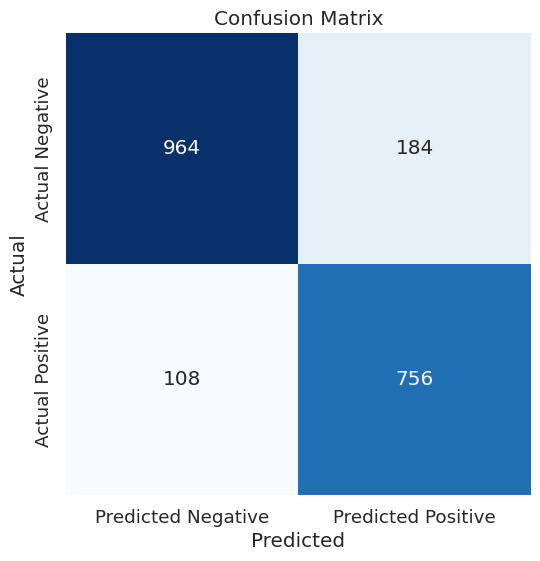

In [166]:
# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

# plot activation maps

In [68]:
class ActivationMapModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, x):
        feature_map = self.feature_map(x)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        avg_output_flatten = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flatten)
        return pred, feature_map

In [ ]:
model = ActivationMapModel()
model.load_state_dict(torch.load("/content/pneumonia_model.pt"), strict=False)
model.to(device)
model.eval()

In [168]:
def cam(model, img):
    with torch.no_grad():
        a = model(img.unsqueeze(0).unsqueeze(0))
        print(a)
        pred, freatures = model(img.unsqueeze(0).unsqueeze(0))

    freatures = freatures.reshape((512, 49))
    weights_params = list(model.model.fc.parameters())[0]
    weight = weights_params.detach()

    cam = torch.matmul(weight, freatures)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [77]:
from matplotlib.patches import Rectangle
def visualize_cam(img, cam_img, pred, data):
    cam_img = transforms.functional.resize(cam_img.unsqueeze(0), size=(224, 224))[0]
    fig, axis = plt.subplots(1, 2, figsize=(10, 11))
    axis[0].imshow(img, cmap='bone')
    axis[1].imshow(img, cmap='bone')
    axis[1].imshow(cam_img, cmap='jet', alpha=0.3)
    for _, row in data.iterrows():
        x, y, w, h = row.x*0.21875, row.y*0.21875, row.width*0.21875, row.height*0.21875
        rectangle = Rectangle(xy=(x,y),width=w, height=h, edgecolor="red",fc="none", alpha = 0.5)
        axis[0].add_patch(rectangle)
    axis[0].set_title(id + "\n Actual place of Pneumonia")
    plt.title("Predicated place of Pneumonia" if pred > 0.5 else "No Pneumonia")


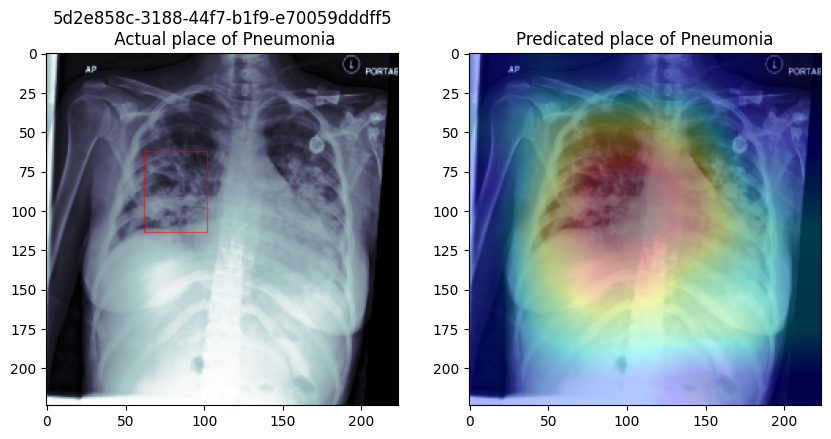

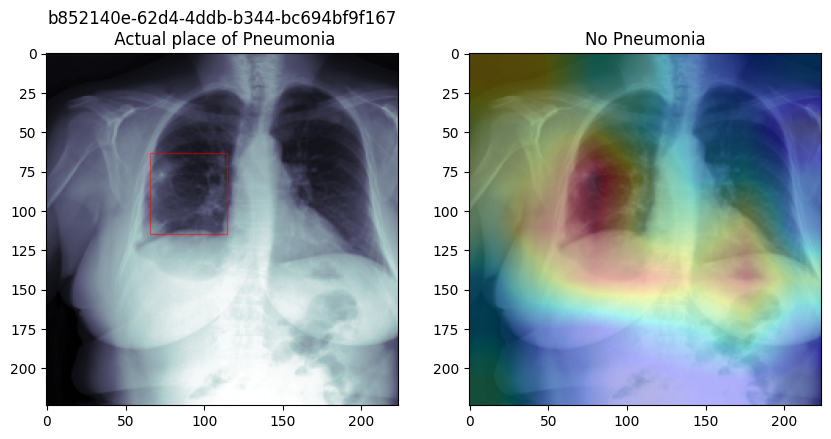

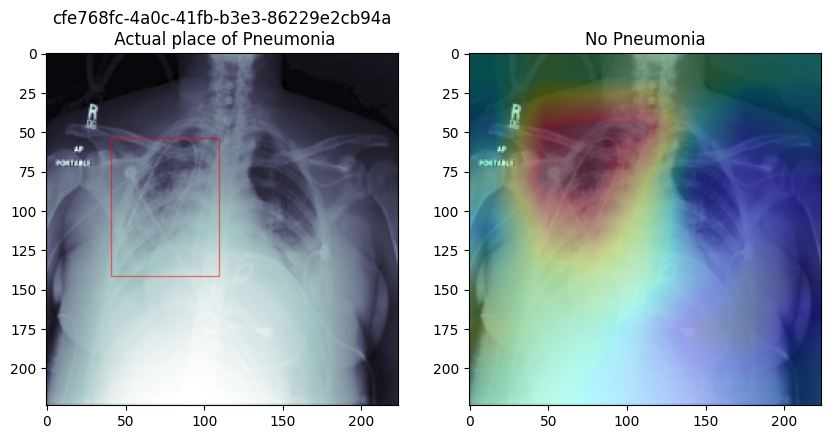

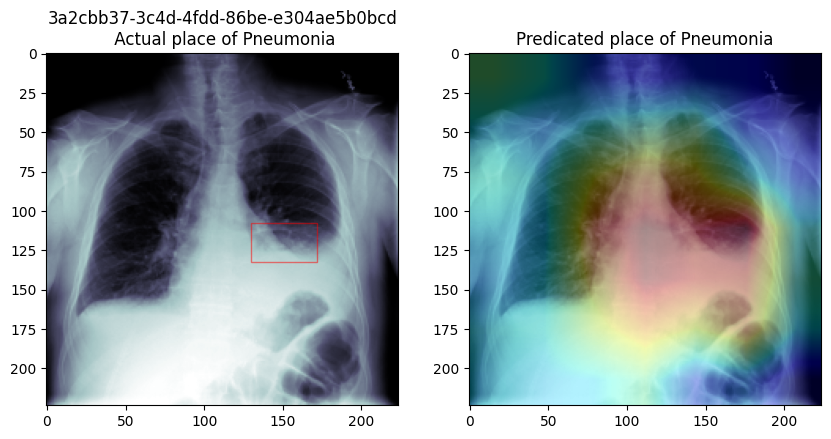

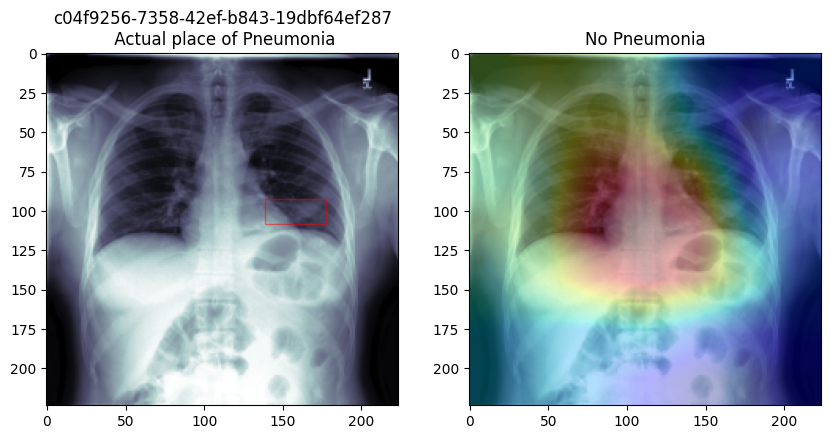

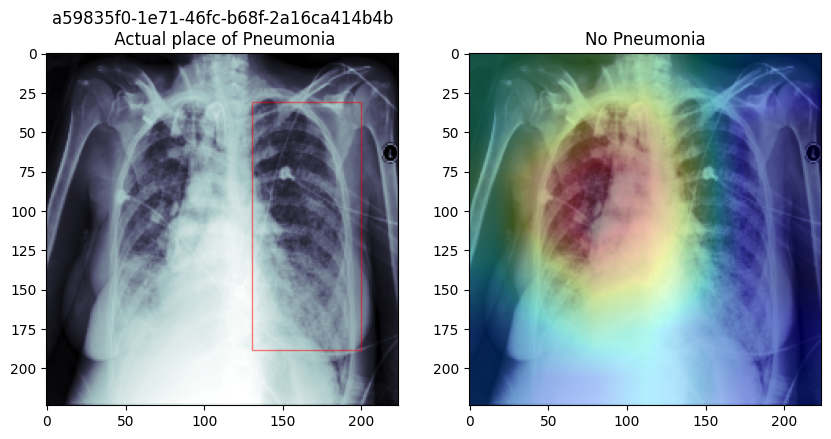

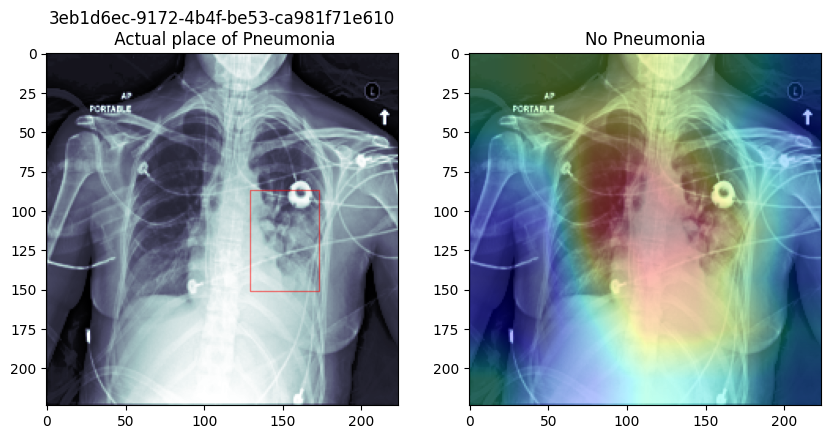

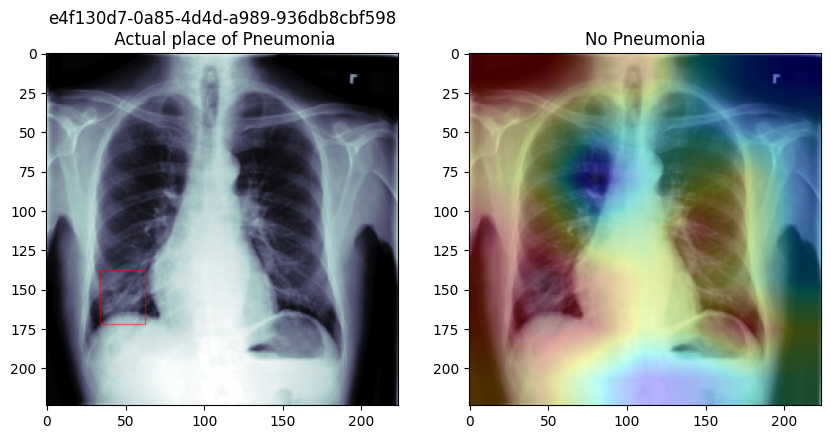

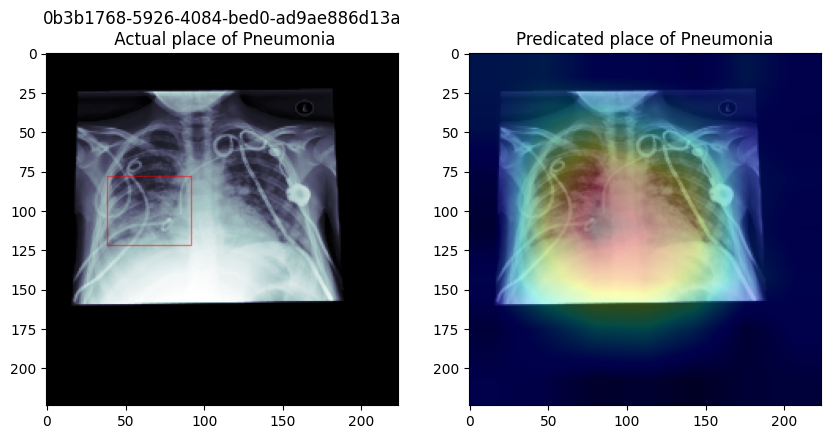

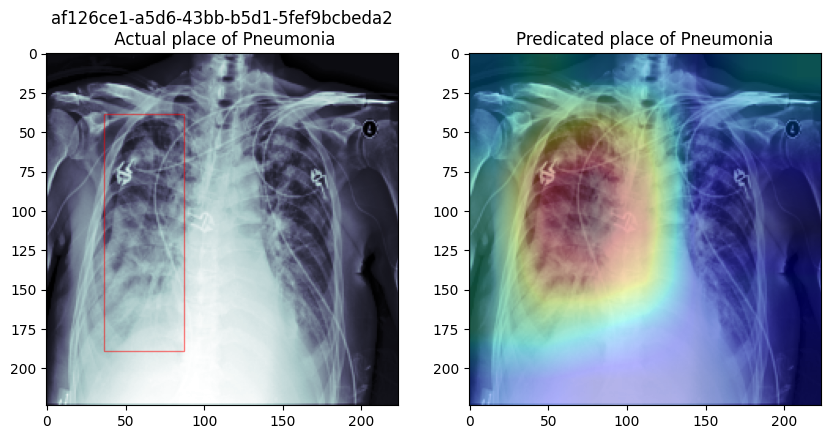

In [92]:
count = 0
i = 0
while(count < 10):
    id = val_dataset[i]["id"]
    df = labels.loc[labels.index == id]
    img = val_dataset[i]["image"][0]
    activation_map, pred = cam(model, img.cuda())
    for _, row in df.iterrows():
        if row.Target:
            visualize_cam(img, activation_map, pred, df)
            count +=1
            break
    i += 1
